In [2]:
import pandas as pd

data = pd.read_csv("bike_daily.csv")
data.head()


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [3]:
data.isnull().sum()


instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

Aucune valeur manquante

In [4]:
print(data.dtypes)

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object


Clairement, season, month week day, year, holiday, sont des variables catégorielles même si ce sont des nombres. On va faire PCA sur les variables temp, atemp, hum, windspeed. 
On va traiter les variables continues. On va quand même faire aussi l'analyse factorielle parce que season, yr, month peuvent quand même être incluse dans un neural network. 

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

X = data[["temp", "atemp", "hum", "windspeed"]]
X.describe()

,temp,atemp,hum,windspeed
count,731.000000,731.000000,731.000000,731.000000
mean,0.495385,0.474354,0.627894,0.190486
std,0.183051,0.162961,0.142429,0.077498
min,0.059130,0.079070,0.000000,0.022392
25%,0.337083,0.337842,0.520000,0.134950
50%,0.498333,0.486733,0.626667,0.180975
75%,0.655417,0.608602,0.730209,0.233214
max,0.861667,0.840896,0.972500,0.507463


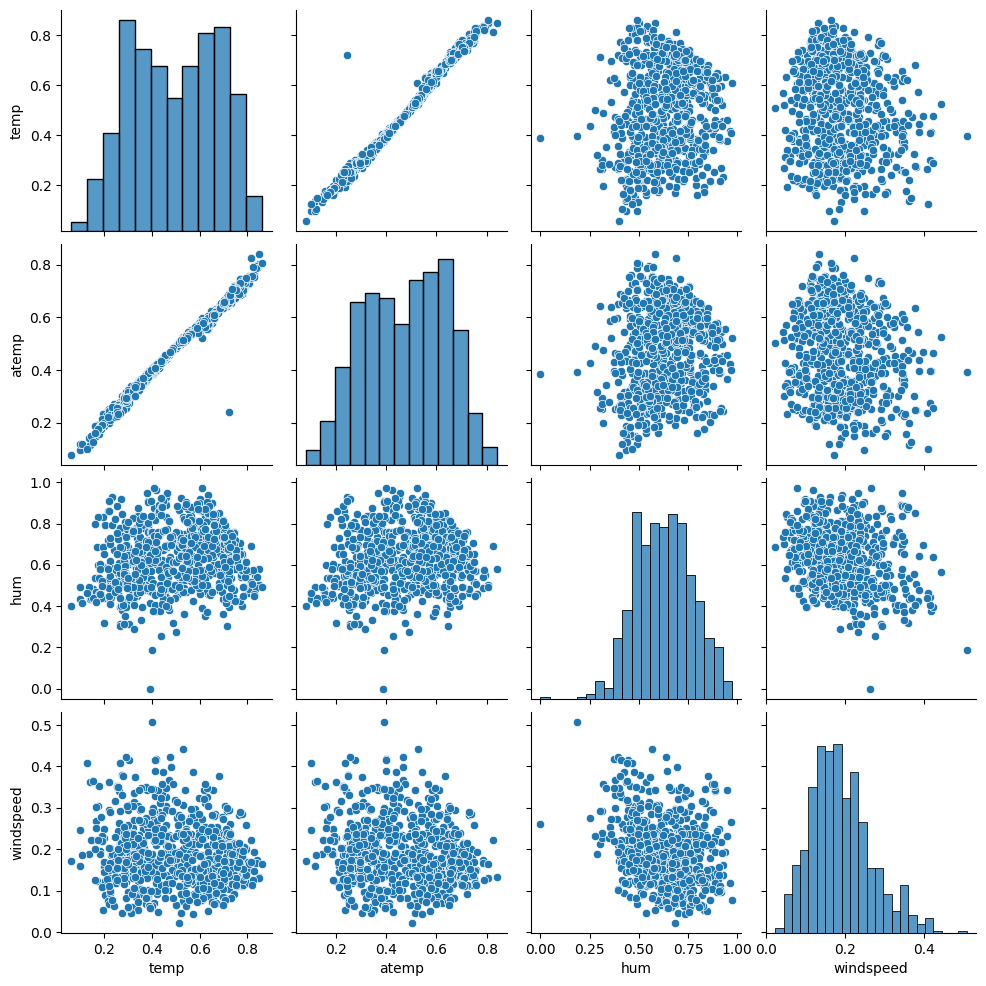

In [31]:
import seaborn as sns

sns.pairplot(X)
plt.show()

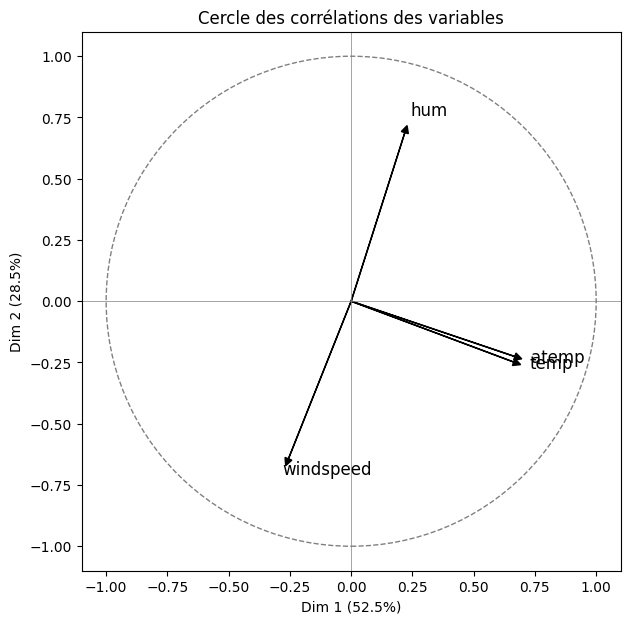

In [6]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)

pca.fit(X_scaled)
components = pca.components_.T  

fig, ax = plt.subplots(figsize=(7,7))

circle = plt.Circle((0,0), 1, color='grey', fill=False, linestyle='--')
ax.add_artist(circle)

for i, var in enumerate(X.columns):
    x = components[i, 0]
    y = components[i, 1]
    ax.arrow(0, 0, x, y, 
             head_width=0.03, 
             head_length=0.03, 
             linewidth=1, 
             color="black")
    ax.text(x * 1.1, y * 1.1, var, fontsize=12)

ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_xlabel(f"Dim 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
ax.set_ylabel(f"Dim 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
ax.set_title("Cercle des corrélations des variables")
ax.axhline(0, color='grey', linewidth=0.5)
ax.axvline(0, color='grey', linewidth=0.5)
ax.set_aspect('equal')

plt.show()

On voit que atemp et temp sont fortement corrélé et représente les vecteurs qui représente le mieux la dimension principale. Tandis que windspeed et humidité sont corrélé négativement avec des flèches dont l'angle est proche de 180°. 

C:\Users\enzom\AppData\Local\Temp\ipykernel_16380\1711461745.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_factor[col] = X_factor[col].astype("category")
C:\Users\enzom\AppData\Local\Temp\ipykernel_16380\1711461745.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_factor[col] = X_factor[col].astype("category")
C:\Users\enzom\AppData\Local\Temp\ipykernel_16380\1711461745.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

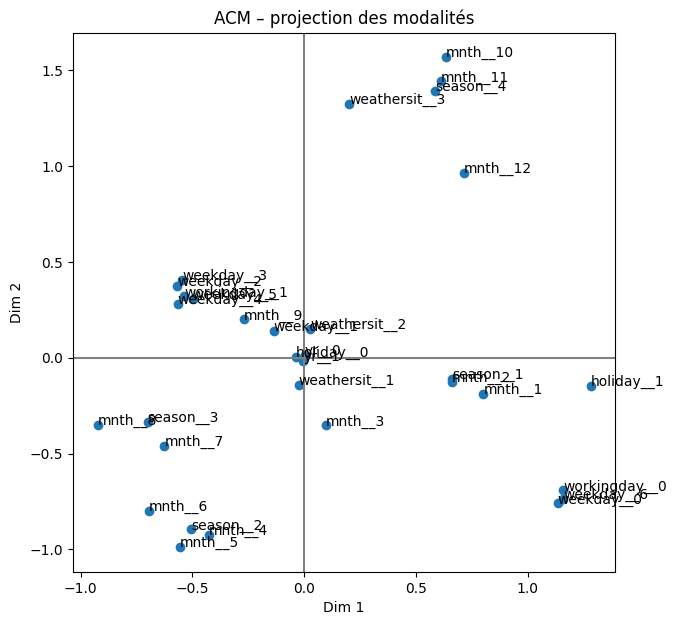

In [7]:
import prince

X_factor = data[["yr", "season", "mnth", "holiday",
                 "weekday", "workingday", "weathersit"]]

# Convertir en catégories
for col in X_factor.columns:
    X_factor[col] = X_factor[col].astype("category")

# ACM avec engine correct
mca = prince.MCA(
    n_components=2,
    n_iter=5,
    engine='sklearn', 
    random_state=42
)

mca = mca.fit(X_factor)

coords = mca.column_coordinates(X_factor)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 7))

coords = mca.column_coordinates(X_factor)

ax.scatter(coords[0], coords[1])

for i, txt in enumerate(coords.index):
    ax.annotate(txt, (coords.iloc[i,0], coords.iloc[i,1]))

plt.axhline(0, color="grey")
plt.axvline(0, color="grey")
plt.title("ACM – projection des modalités")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()



On voit nettement des clusters. season_4 est proche de mnth_11 mnth_12... season_4 est l'hiver. Pour éviter d'avoir un cercle de corélation trop dense, on va supprimer de l'analyse factorielle les mois et garder uniquement les saisons. 

C:\Users\enzom\AppData\Local\Temp\ipykernel_16380\2040214358.py:90: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


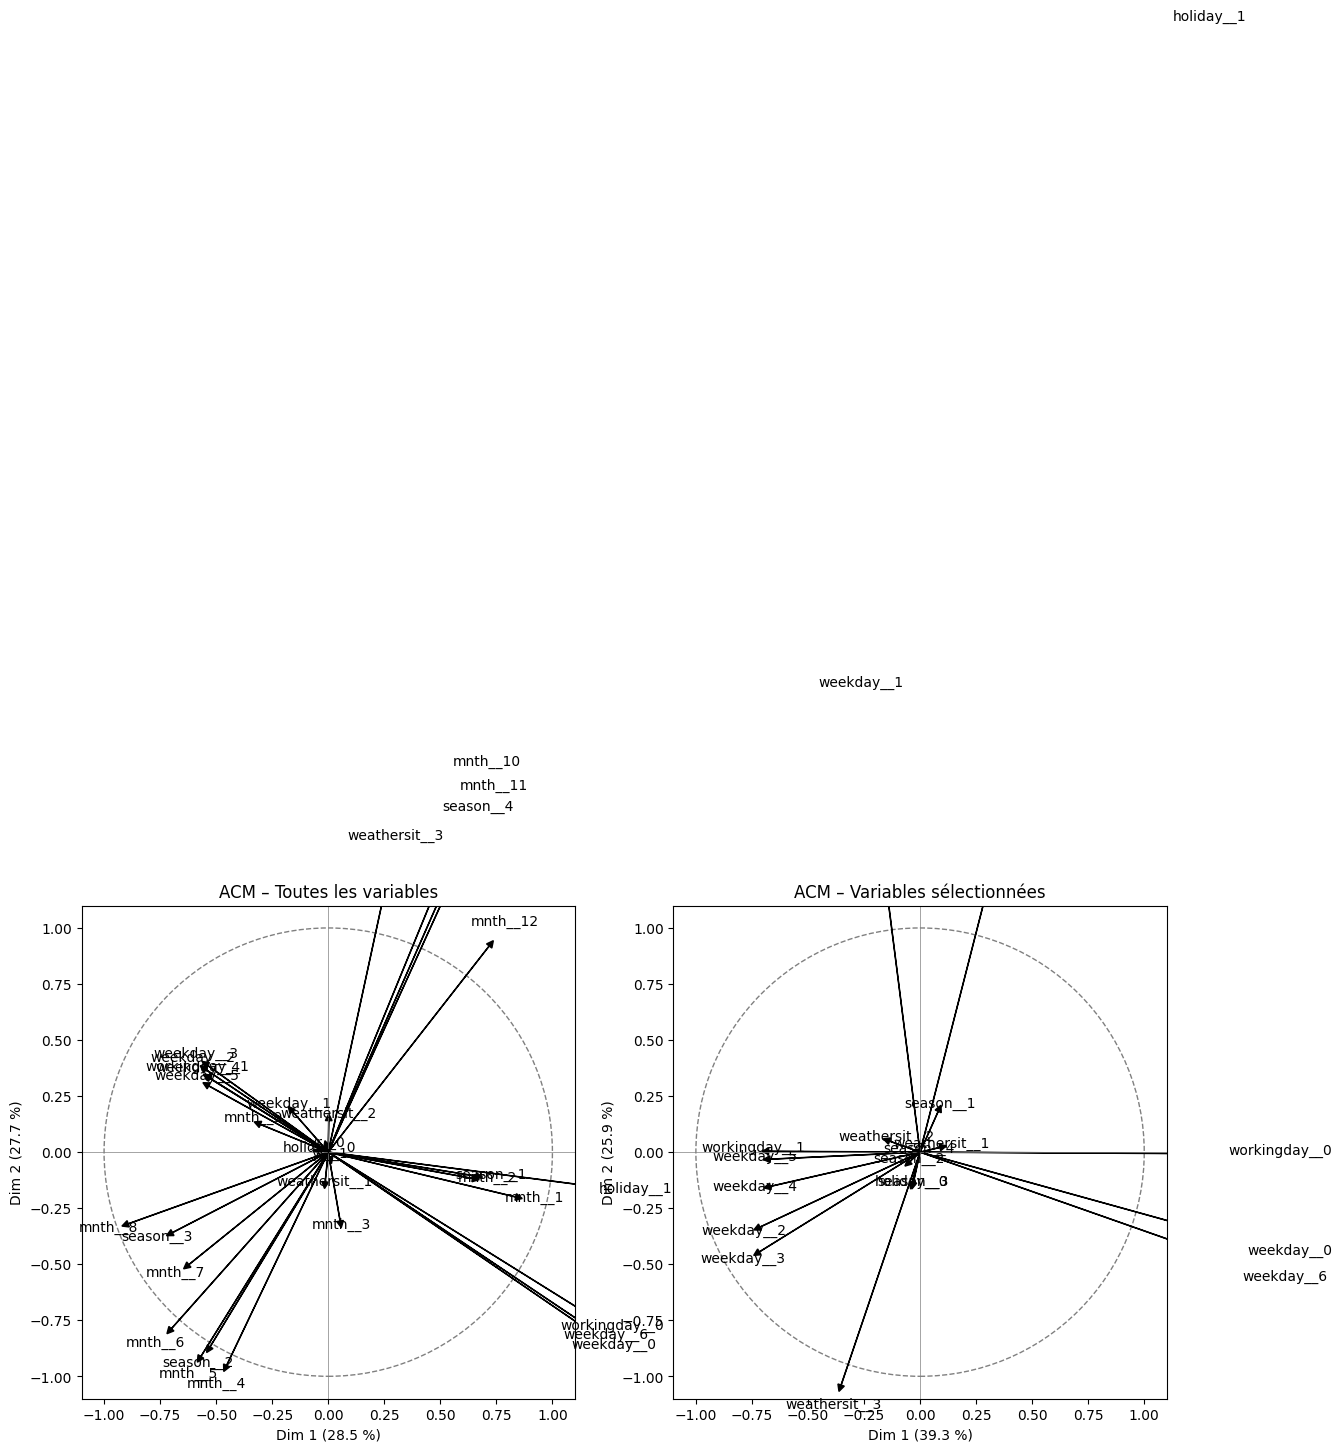

In [33]:
variables_categorielles = [
    "season", "holiday",
    "weekday", "workingday", "weathersit", "mnth", "yr"
]
variables_cat2 = [
    "season", "holiday",
    "weekday", "workingday", "weathersit"
]

X_factor = data[variables_categorielles].copy()
X_factor = X_factor.astype("category")

X_factor2 = data[variables_cat2].copy()
X_factor2 = X_factor2.astype("category")

mca = prince.MCA(
    n_components=2,
    n_iter=5,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
mca.fit(X_factor)

mca2 = prince.MCA(
    n_components=2,
    n_iter=5,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
mca2.fit(X_factor2)

coords = mca.column_coordinates(X_factor)
inertia = mca.eigenvalues_
dim1, dim2 = inertia[0], inertia[1]

coords2 = mca2.column_coordinates(X_factor2)
inertia2 = mca2.eigenvalues_
dim1_2, dim2_2 = inertia2[0], inertia2[1]

fig, ax = plt.subplots(1, 2, figsize=(14, 7))

cercle1 = plt.Circle((0, 0), 1, color='grey', fill=False, linestyle='--')
ax[0].add_artist(cercle1)

for modalite, (x, y) in coords.iterrows():
    ax[0].arrow(
        0, 0, x, y,
        head_width=0.03,
        head_length=0.03,
        linewidth=1,
        color="black"
    )
    ax[0].text(x * 1.1, y * 1.1, modalite, fontsize=10, ha='center')

ax[0].set_xlim(-1.1, 1.1)
ax[0].set_ylim(-1.1, 1.1)
ax[0].set_xlabel(f"Dim 1 ({dim1 * 100:.1f} %)")
ax[0].set_ylabel(f"Dim 2 ({dim2 * 100:.1f} %)")
ax[0].set_title("ACM – Toutes les variables")
ax[0].axhline(0, color='grey', linewidth=0.5)
ax[0].axvline(0, color='grey', linewidth=0.5)
ax[0].set_aspect('equal')

cercle2 = plt.Circle((0, 0), 1, color='grey', fill=False, linestyle='--')
ax[1].add_artist(cercle2)

for modalite, (x, y) in coords2.iterrows():
    ax[1].arrow(
        0, 0, x, y,
        head_width=0.03,
        head_length=0.03,
        linewidth=1,
        color="black"
    )
    ax[1].text(x * 1.1, y * 1.1, modalite, fontsize=10, ha='center')

ax[1].set_xlim(-1.1, 1.1)
ax[1].set_ylim(-1.1, 1.1)
ax[1].set_xlabel(f"Dim 1 ({dim1_2 * 100:.1f} %)")
ax[1].set_ylabel(f"Dim 2 ({dim2_2 * 100:.1f} %)")
ax[1].set_title("ACM – Variables sélectionnées")
ax[1].axhline(0, color='grey', linewidth=0.5)
ax[1].axvline(0, color='grey', linewidth=0.5)
ax[1].set_aspect('equal')

plt.tight_layout()
plt.show()

J'ai commencé mon approche en enlevant les features contenant l'année et les mois. Nous avons obtenu le cercle de corrélation de droite. Nous avons dans un premier temps analysé que la composante principale capte essentiellement la variabilité comprise dans workingday = False. L’axe 2 oppose :
des jours particuliers (lundi, jour férié) à des situations de météo très dégradée (weathersit_3). Les deux axes représentent 65,2% de l’inertie, soit une bonne représentation globale pour une ACM. Si on veut par la suite éliminer ou ajouter des variables catégorielles dans notre modèle mais pas trop, on pourrait tester avec un set de variables non corrélés. On va essayer une régression linéaire simple avec les variables catégorielles : workingday et weathersit même si weathersit est potentielement fortement corrélé aux données quantitatives de vent, d'humidité et de température. Si les p_values sont faibles. On les incluera dans le modèle. Prendre holiday et working day même s'ils apparraissent décorrélé sur le cercle, on sait en pratique qu'ils sont fortement corrélés. 

En plottant le cercle de corrélation avec l'ensemble des features catégorielles, on a désormais plus le problème avec les features holiday et working day qui apparaisse plus corrélé. On dégage mieux le fait qu'il y ait un groupe [bad weather, mois de l'hiver] et à l'opposé [good weather, mois d'été] et perpendiculairement, les jours travaillés et les jours non travaillé. 

In [9]:
contingence = pd.crosstab(data["holiday"], data["workingday"],
                   rownames=["holiday"],
                   colnames=["workingday"])

print(contingence)

workingday    0    1
holiday             
0           210  500
1            21    0


Comme on le voit sur la matrice de contingence on ne peut pas travailler et être en vacances. Le cas contraire aurait remis en question l'intégrité de la base de donnée. 

In [38]:
import statsmodels.api as sm

y = data["cnt"]
test_cat = ["weathersit", "workingday"]

X_categories = X_factor.loc[:,test_cat]
x = pd.get_dummies(X_categories, drop_first=True)

x = x.astype(int)
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     28.56
Date:                Thu, 27 Nov 2025   Prob (F-statistic):           1.82e-17
Time:                        16:10:23   Log-Likelihood:                -6529.0
No. Observations:                 731   AIC:                         1.307e+04
Df Residuals:                     727   BIC:                         1.308e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         4657.5901    129.213     36.046   

Le modèle de régression linéaire avec les variables catégorielles démontre que pour les features catégorielles choisient expliquent en parti le nombre de vélos utilisés au total. (p_values < 0.05)

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split 
import lightning as pl
from lightning.pytorch.utilities.model_summary import ModelSummary
from simplelogger import SimpleLogger
import pandas as pd


y = data["cnt"]
y = y.values.reshape(-1, 1)

X_categories = X_factor.loc[:, test_cat]
x_cat = pd.get_dummies(X_categories, drop_first=True)
#On enlève les premières modalités pour éviter la redondance dans les variables catégorielles : workingday_1 + workingday_0 = 1

X_final = pd.concat([pd.DataFrame(X_scaled), x_cat.reset_index(drop=True)], axis=1)
X_final = X_final.astype(float)

print("Données finales :")
print(X_final.head())
print(f"Shape : {X_final.shape}")

stratify_columns = data[["weathersit", "workingday"]]

x_train, x_test, y_train, y_test = train_test_split(
    X_final.values,
    y,
    stratify=stratify_columns,
    test_size=0.2,
    random_state=123
)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(f"\nx_train shape : {x_train.shape}")
print(f"y_train shape : {y_train.shape}")
print(f"x_test shape : {x_test.shape}")
print(f"y_test shape : {y_test.shape}")

Données finales :
          0         1         2         3  weathersit_2  weathersit_3  \
0 -0.826662 -0.679946  1.250171 -0.387892           1.0           0.0   
1 -0.721095 -0.740652  0.479113  0.749602           1.0           0.0   
2 -1.634657 -1.749767 -1.339274  0.746632           0.0           0.0   
3 -1.614780 -1.610270 -0.263182 -0.389829           0.0           0.0   
4 -1.467414 -1.504971 -1.341494 -0.046307           0.0           0.0   

   workingday_1  
0           0.0  
1           0.0  
2           1.0  
3           1.0  
4           1.0  
Shape : (731, 7)

x_train shape : torch.Size([584, 7])
y_train shape : torch.Size([584, 1])
x_test shape : torch.Size([147, 7])
y_test shape : torch.Size([147, 1])


 ## Model Definition

  | Name       | Type       | Params | Mode  | In sizes | Out sizes
-------------------------------------------------------------------------
0 | activation | ReLU       | 0      | train | [1, 7]   | [1, 7]   
1 | layers     | Sequential | 4.5 K  | train | [1, 7]   | [1, 1]   
2 | mse        | MSELoss    | 0      | train | ?        | ?        
-------------------------------------------------------------------------
4.5 K     Trainable params
0         Non-trainable params
4.5 K     Total params
0.018     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


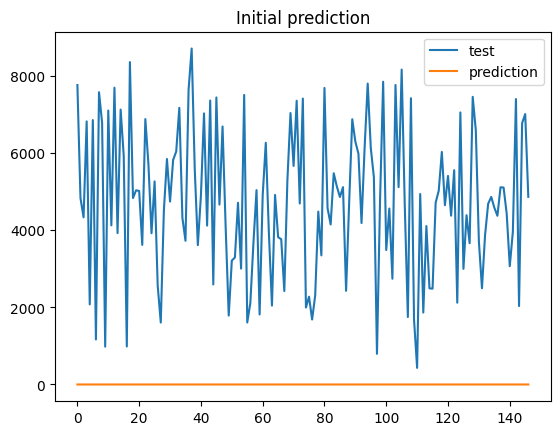

In [ ]:
class Bike_model(pl.LightningModule):
    def __init__(self, input_dim, lr=1e-3):
        super(Bike_model, self).__init__()
        self.activation = nn.ReLU()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)   # deux sorties : casual, registered
        )
        self.mse = nn.MSELoss()
        self.lr = lr
        self.example_input_array = torch.zeros(1, 7)

    def forward(self, x):
        return self.layers(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        yhat = self.layers(x)
        loss = self.mse(yhat, y)
        mae = (yhat - y).abs().mean(1)
        self.log(f"train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log(f"train_mae", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return [optimizer]

    def validation_step(self, batch, batch_idx):
        x, y = batch
        yhat = self.forward(x)
        loss = self.mse(yhat, y)
        self.log(f"val_loss", loss, on_epoch=True, on_step=False, prog_bar=True)
        self.log(f"val_mae", loss, on_step=False, on_epoch=True, prog_bar=True)

model = PovertyLineModel(lr=1e-4)
summary = ModelSummary(model)
print(summary)
plt.plot(y_test, label="test")
plt.plot(model(x_test).detach(), label="prediction")
plt.title("Initial prediction")
plt.legend()

 ## Train the Model

In [15]:
trainer = pl.Trainer(
    max_epochs=150,
    logger=SimpleLogger(),
    enable_checkpointing=False,
    log_every_n_steps=1,
)  # logger=False, enable_checkpointing=False to avoid polluting your workspace with lightning_logs and checkpoints

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [19]:
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=test_loader)


  | Name       | Type       | Params | Mode  | In sizes | Out sizes
-------------------------------------------------------------------------
0 | activation | ReLU       | 0      | train | [1, 7]   | [1, 7]   
1 | layers     | Sequential | 4.5 K  | train | [1, 7]   | [1, 1]   
2 | mse        | MSELoss    | 0      | train | ?        | ?        
-------------------------------------------------------------------------
4.5 K     Trainable params
0         Non-trainable params
4.5 K     Total params
0.018     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


c:\Users\enzom\OneDrive\Bureau\MINES\SDD\NN\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\enzom\OneDrive\Bureau\MINES\SDD\NN\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 149: 100%|██████████| 73/73 [00:00<00:00, 89.27it/s, v_num=Data, val_loss=2.29e+6, val_mae=2.29e+6, train_loss=2.21e+6, train_mae=2.21e+6] 

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 73/73 [00:00<00:00, 88.98it/s, v_num=Data, val_loss=2.29e+6, val_mae=2.29e+6, train_loss=2.21e+6, train_mae=2.21e+6]


 ## Evaluate Model

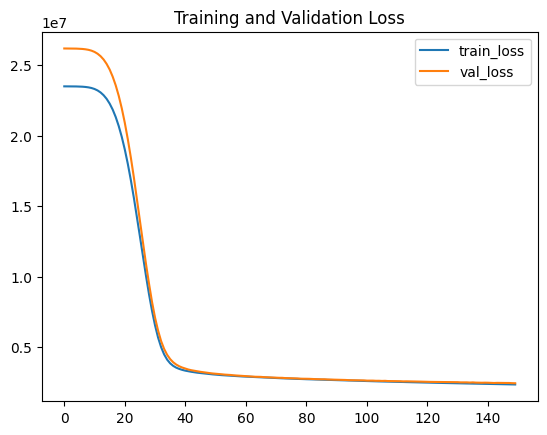

In [ ]:
plt.plot(trainer.logger.metrics["train_loss"], label="train_loss")
plt.plot(trainer.logger.metrics["val_loss"], label="val_loss")
plt.title("Training and Validation Loss")
plt.legend()

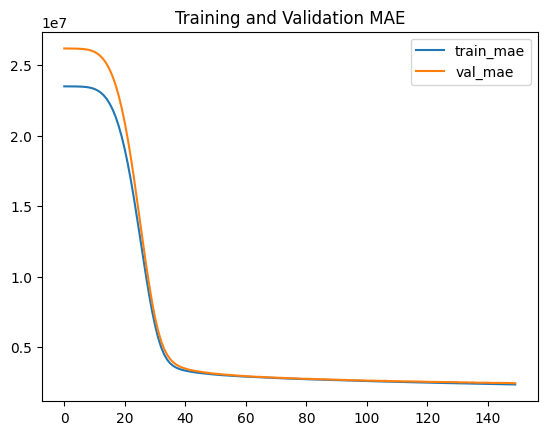

In [ ]:
plt.plot(trainer.logger.metrics["train_mae"], label="train_mae")
plt.plot(trainer.logger.metrics["val_mae"], label="val_mae")
plt.title("Training and Validation MAE")
plt.legend()

On obtient des résultats corrects ? 

Dans un second temps on décide d'entraîner 2 RNN différents parce que dans nos données d'entraînement on fait la distinction entre le nombre d’usagers à la fois abonnés et non abonnés.

In [40]:
import statsmodels.api as sm

y = data["registered"]
test_cat = ["weekday", "season"]

X_categories = X_factor.loc[:,test_cat]
x = pd.get_dummies(X_categories, drop_first=True)
print(x)
x = x.astype(int)
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
print(model.summary())

     weekday_1  weekday_2  weekday_3  weekday_4  weekday_5  weekday_6  \
0        False      False      False      False      False       True   
1        False      False      False      False      False      False   
2         True      False      False      False      False      False   
3        False       True      False      False      False      False   
4        False      False       True      False      False      False   
..         ...        ...        ...        ...        ...        ...   
726      False      False      False       True      False      False   
727      False      False      False      False       True      False   
728      False      False      False      False      False       True   
729      False      False      False      False      False      False   
730       True      False      False      False      False      False   

     season_2  season_3  season_4  
0       False     False     False  
1       False     False     False  
2       False  

Le mieux : faire des courches pour évaluer y_1 et y_2 et après une couche y_final = somme des 2 sigma(supérieur pu inférieur à 4000). 

In [ ]:
y = data["cnt"]
y = y.values.reshape(-1, 1)

X_categories = X_factor.loc[:, test_cat]
x_cat = pd.get_dummies(X_categories, drop_first=True)
#On enlève les premières modalités pour éviter la redondance dans les variables catégorielles : workingday_1 + workingday_0 = 1

X_final = pd.concat([pd.DataFrame(X_scaled), x_cat.reset_index(drop=True)], axis=1)
X_final = X_final.astype(float)

print("Données finales :")
print(X_final.head())
print(f"Shape : {X_final.shape}")

stratify_columns = data[["weekday", "season"]]

x_train, x_test, y_train, y_test = train_test_split(
    X_final.values,
    y,
    stratify=stratify_columns,
    test_size=0.2,
    random_state=123
)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


In [ ]:
class PovertyLineModel(pl.LightningModule):
    def __init__(self, input_dim, lr=1e-3):
        super(PovertyLineModel, self).__init__()
        self.activation = nn.ReLU()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)   # deux sorties : casual, registered
        )
        self.mse = nn.MSELoss()
        self.lr = lr
        self.example_input_array = torch.zeros(1, 7)

    def forward(self, x):
        return self.layers(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        yhat = self.layers(x)
        loss = self.mse(yhat, y)
        mae = (yhat - y).abs().mean(1)
        self.log(f"train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log(f"train_mae", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return [optimizer]

    def validation_step(self, batch, batch_idx):
        x, y = batch
        yhat = self.forward(x)
        loss = self.mse(yhat, y)
        self.log(f"val_loss", loss, on_epoch=True, on_step=False, prog_bar=True)
        self.log(f"val_mae", loss, on_step=False, on_epoch=True, prog_bar=True)

model = PovertyLineModel(lr=1e-4)
summary = ModelSummary(model)
print(summary)
plt.plot(y_test, label="test")
plt.plot(model(x_test).detach(), label="prediction")
plt.title("Initial prediction")
plt.legend()